In [1]:
import os
import glob
import pickle
import tensorflow as tf    # used for creating tensors out of the dataset and training the model
import tensorflow_hub as hub    # downloading and using pre-trained 0models
import numpy as np
import h5py   # to manipulate the dataset as it's in `.h5` format
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report   # essential for model's evaluation
from sklearn.metrics import f1_score
from tqdm import tqdm   # getting a progress bar for an iterable object
import random

In [2]:
train_df64 = pd.read_csv("C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect/dataset/train64.csv")
# making rest columns which are not labeled good as damaged
train_df64["indication_type"] = train_df64.indication_type.apply(lambda row: "damaged" if row!="good" else "good")
train_df64["indication_value"] = train_df64.indication_value.apply(lambda row: 1 if row!=0 else 0)
train_df64.head()

,index,angle,indication_type,indication_value,split
0,48000,0,good,0,train
1,48001,80,good,0,train
2,48002,100,good,0,train
3,48003,100,good,0,train
4,48004,0,good,0,train


In [3]:
# determining proportion of good and damaged
train_df64.indication_type.value_counts(normalize=True).round(2)

indication_type
damaged    0.83
good       0.17
Name: proportion, dtype: float64

(array([0, 1]), [Text(0, 0, 'damaged'), Text(1, 0, 'good')])

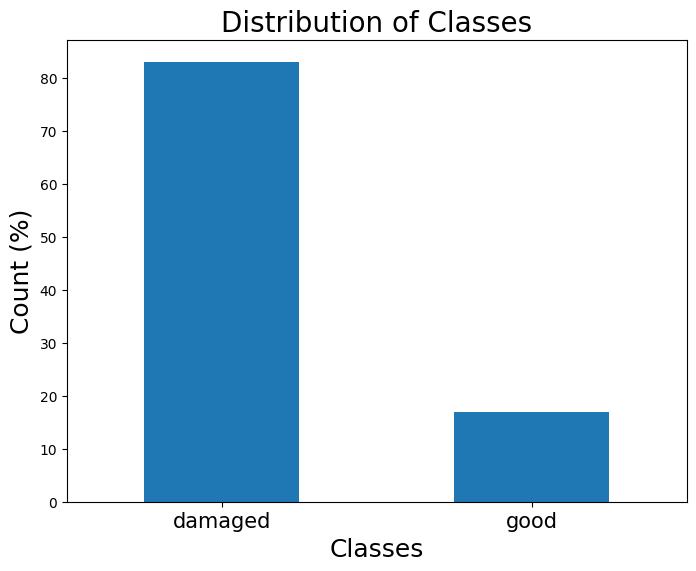

In [4]:
(train_df64.indication_type.value_counts(normalize=True).round(2)*100).to_frame().plot.bar(legend=False, figsize=(8, 6))
plt.xlabel('Classes', fontsize=18)
plt.ylabel("Count (%)", fontsize=18)
plt.title("Distribution of Classes", fontsize=20)
plt.xticks(rotation=0, fontsize=15)

In [ ]:
# HDF5 file is opened and list of classes is retreived
# each and every class is iterated and images are created based on angles listed in csv
# train data generated in the directory separately into good and damaged folders where good images are augmented using horizontal and vertical flip
# similarly done for test directory but here augmentation is not performed

# create an object that will take the dataset and produce the dataset in a format required for tensorflow dataset's API
class H5ToStorage:
  def __init__(self, hdf_path, ds_name="train"):
    self.path = hdf_path

    self.classes = []
    with h5py.File(self.path, 'r') as hf:
      for class_ in hf:
        self.classes.append(class_)

    self.name = ds_name

  # a generator to load the (img, class, angle)
  def generate_img_arr(self):
    for class_ in self.classes:
      with h5py.File(self.path, 'r') as hf:
        for angle in hf[class_]:
            for img in hf[class_][f"{angle}"]:
                yield img, class_, angle

  # utilize the generator to create new images and load it back to Storage
  def generate_train_dirs(self):
    # create the dataset's directories
    path = "/content/drive/MyDrive/BE_project_dataset/working/train"
    os.makedirs(f"{path}/good/")
    os.makedirs(f"{path}/damaged/")

    random_flip = tf.keras.layers.RandomFlip("horizontal_and_vertical")

    gen = self.generate_img_arr()
    metadata = {}

    for i, data in enumerate(gen):
        img, label, angle = data
        if label == "good":
          for j in range(4):
            img_path = f"{path}/{label}/{i}_aug{j}.jpeg"
            # the "good" images in train directory are augmented since the proportion is very low
            img = random_flip(tf.expand_dims(np.squeeze(img), axis=2)*255., training=True)
            plt.imsave(img_path, np.squeeze(img), cmap="gray")
        else:
          img_path = f"{path}/damaged/{i}.jpeg"
          plt.imsave(img_path, np.squeeze(img)*255., cmap="gray")

        metadata[img_path] = angle
    return metadata

  def generate_test_dirs(self):
    # create the dataset's directories
    path = "/content/drive/MyDrive/BE_project_dataset/working/test"
    os.makedirs(f"{path}/good/")
    os.makedirs(f"{path}/damaged/")

    gen = self.generate_img_arr()
    metadata = {}

    for i, data in enumerate(gen):
        img, label, angle = data
        if label == "good":
          img_path = f"{path}/{label}/{i}.jpeg"
          plt.imsave(img_path, np.squeeze(img)*255., cmap="gray")
        else:
          img_path = f"{path}/damaged/{i}.jpeg"
          plt.imsave(img_path, np.squeeze(img)*255., cmap="gray")

        metadata[img_path] = angle

    return metadata

  def to_storage(self):
    if self.name == "train":
      self.generate_train_dirs()

    elif self.name == "test":
      self.generate_test_dirs()

In [5]:
test_dir = "C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect/working/test"
train_dir = "C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect/working/train"

In [ ]:
#  generate train data
train_gen = H5ToStorage("/content/drive/MyDrive/BE_project_dataset/matchingtDATASET_train_64.h5", "train")
train_dict = train_gen.to_storage()

In [ ]:
#  generate test data
test_gen = H5ToStorage("/content/drive/MyDrive/BE_project_dataset/matchingtDATASET_test_64.h5", "test")
test_dict = test_gen.to_storage()

In [6]:
# train and test data pipelines created to load and preprocess images from the train and test directories respectively
# The dataset is then prefetched and cached for optimized performance.
# the ratio of train and test data split is 3:1
# train - 1080000 images and test - 36000 images


# create train data pipeline
IMG_SIZE = (64, 64) # define image size
train_data = tf.keras.utils.image_dataset_from_directory(directory=train_dir,
                                                         image_size=IMG_SIZE,
                                                         color_mode="grayscale",
                                                         label_mode="int", #  label type is encoding of the form `[1, 2, 3, ...]`
                                                         batch_size=len(os.listdir("C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect/working/train/good")) + len(os.listdir("C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect/working/train/damaged")))
                                                        # Batch size is set to be the size of the whole dataset to make loading data into x_train, y_train easier.
class_names = train_data.class_names
print(f"The class_names are as follows: {class_names}")

train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE).\
                        cache()

# create test data pipeline
test_data = tf.keras.utils.image_dataset_from_directory(directory=test_dir,
                                                        image_size=IMG_SIZE,
                                                        color_mode="grayscale",
                                                        shuffle=False,
                                                        batch_size=len(os.listdir("C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect/working/test/good")) + len(os.listdir("C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect/working/test/damaged")),
                                                        label_mode="int")

test_data = test_data.prefetch(buffer_size=tf.data.AUTOTUNE).\
                      cache()

Found 108000 files belonging to 2 classes.
The class_names are as follows: ['damaged', 'good']
Found 36000 files belonging to 2 classes.


In [ ]:
# check the proportions of classes
damaged_counts = 0
for _ in os.listdir(f"C:/Users/vansh/Desktop/BE project/working/train/damaged"):
  damaged_counts += 1

good_counts = 0
for _ in os.listdir(f"C:/Users/vansh/Desktop/BE project/working/train/good"):
  good_counts += 1

total = damaged_counts + good_counts

new_train_df64 = pd.Series({"damaged": damaged_counts/total,
                            "good": good_counts/total}).round(2)
new_train_df64

(array([0, 1]), [Text(0, 0, 'damaged'), Text(1, 0, 'good')])

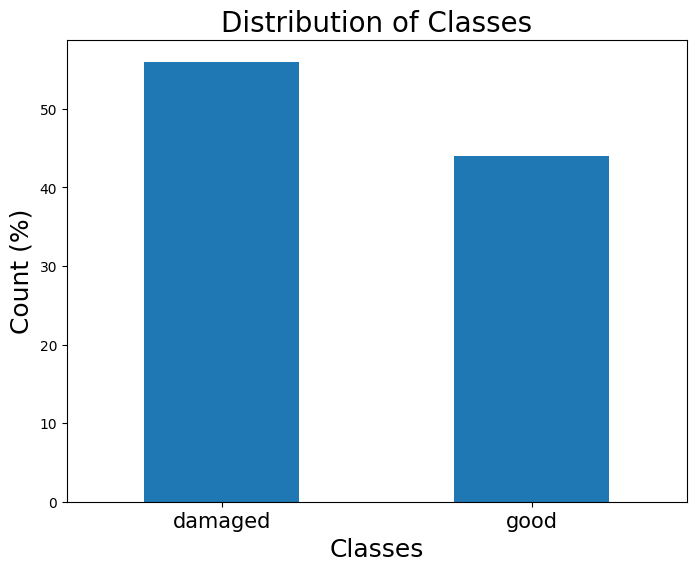

In [8]:
# check the classes distribution
(new_train_df64*100).to_frame().plot.bar(legend=False, figsize=(8, 6))
plt.xlabel('Classes', fontsize=18)
plt.ylabel("Count (%)", fontsize=18)
plt.title("Distribution of Classes", fontsize=20)
plt.xticks(rotation=0, fontsize=15)

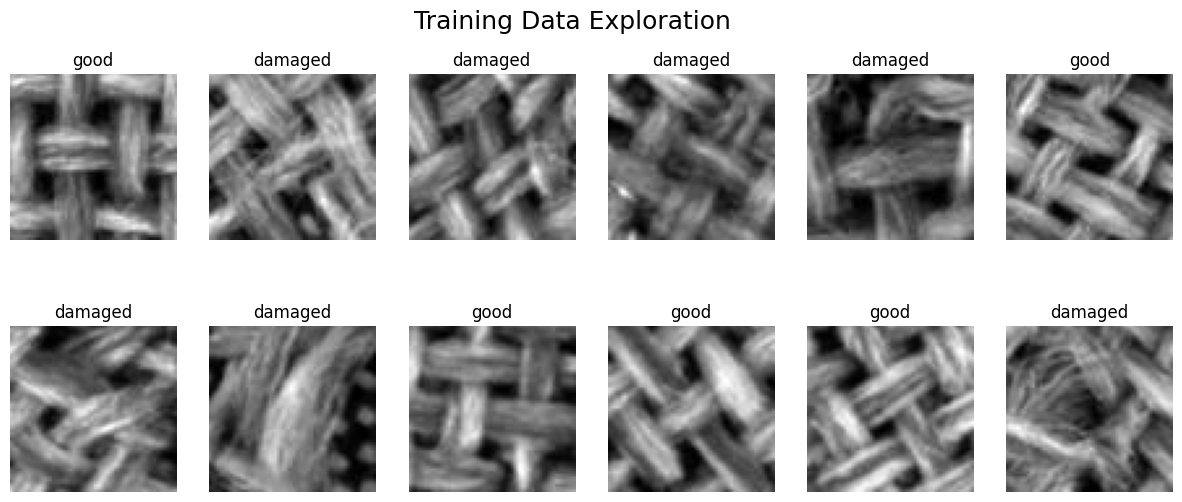

In [9]:
# explore the train data
def explore_data(n_rows, n_cols, figsize):
    count = 0
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize) # plot 20 figures
    fig.suptitle("Training Data Exploration", fontsize=18, y=0.95)
    for data, ax in zip(train_data.shuffle(10000).take(1).unbatch(), axs.ravel()):
        img, label = data

        ax.axis("off")
        ax.set_title(f"{class_names[label]}")
        ax.imshow(np.squeeze(img), cmap="gray")

        count+=1
        if count == n_rows*n_cols:
          break

explore_data(n_rows=2, n_cols=6, figsize=(15, 6))

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [9]:
IMG_SIZE = (64, 64)
BATCH_SIZE = 32  # Adjust the batch size as needed

In [10]:
# Limit GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [12]:
datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True)

In [13]:
train_data = datagen.flow_from_directory(
    directory=train_dir,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="input",  # Assuming the images are grayscale and you want to reconstruct them
    shuffle=True
)

Found 108000 images belonging to 2 classes.


In [22]:
# Build the autoencoder model
encoder = models.Sequential([
    layers.Input(shape=(*IMG_SIZE, 1)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    # layers.Conv2D(32, (3, 3), activation='relu', padding='same', weights=models.layers[1].get_weights(), strides=(1, 1)),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
])

decoder = models.Sequential([
    layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),
    layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'),
])

In [34]:
encoder.compile(optimizer='adam', loss='mse')
decoder.compile(optimizer='adam', loss='mse')

In [35]:
autoencoder = models.Sequential([
    encoder,
    decoder,
])

In [36]:
autoencoder.compile(optimizer='adam', loss='mse')

In [37]:
autoencoder.build((None, *IMG_SIZE, 1))  # Explicitly build the model with a sample input
autoencoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (None, 8, 8, 8)           6104      
                                                                 
 sequential_10 (Sequential)  (None, None, None, 1)     6681      
                                                                 
Total params: 12785 (49.94 KB)
Trainable params: 12785 (49.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [45]:
autoencoder.fit(train_data, epochs=10, verbose=1, steps_per_epoch=len(train_data))

Epoch 1/10
3375/3375 [==============================] - 804s 238ms/step - loss: 0.0066
Epoch 2/10
3375/3375 [==============================] - 742s 220ms/step - loss: 0.0043
Epoch 3/10
3375/3375 [==============================] - 740s 219ms/step - loss: 0.0038
Epoch 4/10
3375/3375 [==============================] - 732s 217ms/step - loss: 0.0036
Epoch 5/10
3375/3375 [==============================] - 775s 230ms/step - loss: 0.0034
Epoch 6/10
3375/3375 [==============================] - 759s 225ms/step - loss: 0.0033
Epoch 7/10
3375/3375 [==============================] - 747s 221ms/step - loss: 0.0032
Epoch 8/10
3375/3375 [==============================] - 747s 221ms/step - loss: 0.0032
Epoch 9/10
3375/3375 [==============================] - 750s 222ms/step - loss: 0.0031
Epoch 10/10
3375/3375 [==============================] - 737s 218ms/step - loss: 0.0033


In [46]:
autoencoder.save("C:/Users/vansh/Desktop/BE project/autoencoder_model.h5")
# Optionally, you can save only the encoder or decoder
encoder.save("C:/Users/vansh/Desktop/BE project/encoder_model.h5")
decoder.save("C:/Users/vansh/Desktop/BE project/decoder_model.h5")

C:\Users\vansh\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
from tensorflow.keras.models import load_model

In [16]:
autoencoder=load_model('C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect/autoencoder_model.h5')

In [17]:
encoder=load_model('C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect/encoder_model.h5')
decoder=load_model('C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect/decoder_model.h5')

1/1 [==============================] - 1s 618ms/step


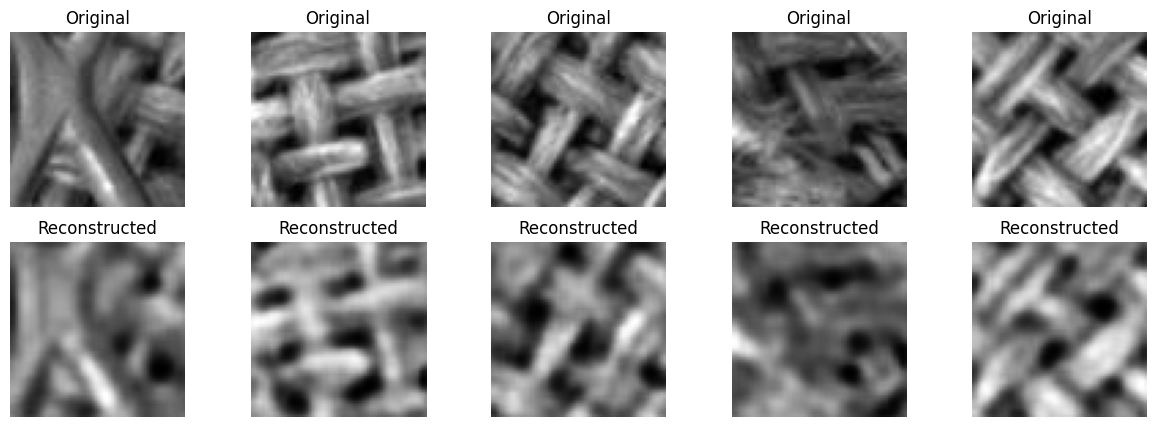

In [18]:
import matplotlib.pyplot as plt

# Function to plot original and reconstructed images
def plot_images(original_images, reconstructed_images, num_samples=5):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 5))

    for i in range(num_samples):
        # Plot original image
        axes[0, i].imshow(original_images[i, :, :, 0], cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')

        # Plot reconstructed image
        axes[1, i].imshow(reconstructed_images[i, :, :, 0], cmap='gray')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')

    plt.show()

# Extract a batch of original images from the generator
original_images, _ = next(iter(train_data))

# Use the trained autoencoder to reconstruct images
reconstructed_images = autoencoder.predict(original_images)

# Plot original and reconstructed images
plot_images(original_images, reconstructed_images)


In [ ]:

import matplotlib.pyplot as plt
import os

# Function to save reconstructed images
def save_reconstructed_images(reconstructed_images, save_path="saved_images"):
    # Create the directory if it does not exist
    if not os.path.exists(save_path):
        os.makedirs(save_path)
        
    for i, reconstructed_image in enumerate(reconstructed_images):
        fig, ax = plt.subplots(figsize=(4, 4))  # Adjust the size as needed

        # Plot reconstructed image without title, white border, and axis
        ax.imshow(reconstructed_image[:, :, 0], cmap='gray')
        ax.axis('off')

        # Save the figure without title, white border, and axis
        plt.savefig(os.path.join(save_path, f'reconstructed_image_{i + 1}.png'), bbox_inches='tight', pad_inches=0)
        plt.close()
# ****************************************************
def save_original_images(original_images, save_path="saved_images"):
    # Create the directory if it does not exist
    if not os.path.exists(save_path):
        os.makedirs(save_path)
        
    for i, original_image in enumerate(original_images):
        fig, ax = plt.subplots(figsize=(4, 4))  # Adjust the size as needed

        # Plot reconstructed image without title, white border, and axis
        ax.imshow(original_image[:, :, 0], cmap='gray')
        ax.axis('off')

        # Save the figure without title, white border, and axis
        plt.savefig(os.path.join(save_path, f'original_image_{i + 1}.png'), bbox_inches='tight', pad_inches=0)
        plt.close()

# Extract a batch of original images from the generator
original_images, _ = next(iter(train_data))

# Use the trained autoencoder to reconstruct images
reconstructed_images = autoencoder.predict(original_images)

# Specify the directory to save the images
save_directory = "C:/Users/vansh/Desktop/BE project/reconstruceted_images"
save_original = "C:/Users/vansh/Desktop/BE project/original_images"
# Save the reconstructed images without plotting
save_reconstructed_images(reconstructed_images, save_path=save_directory)
save_original_images(original_images, save_path=save_original)

In [20]:
test_data = datagen.flow_from_directory(
    directory=test_dir,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="input",  # Assuming the images are grayscale and you want to reconstruct them
    shuffle=True
)

Found 36000 images belonging to 2 classes.


1/1 [==============================] - 0s 118ms/step


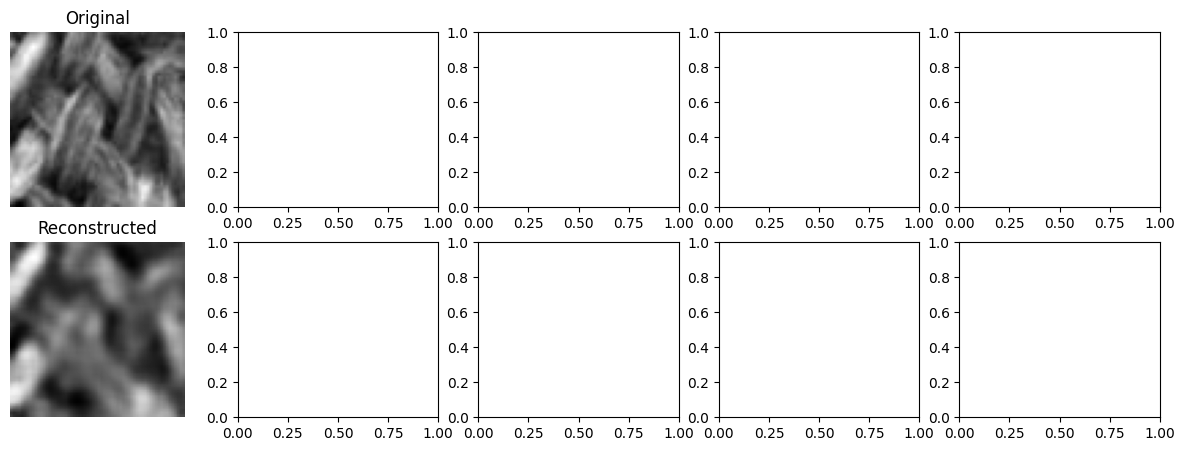

In [42]:
import matplotlib.pyplot as plt

# Function to plot original and reconstructed images
def plot_images(original_images, reconstructed_images, num_samples=5):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 5))

    for i in range(1):
        # Plot original image
        axes[0, i].imshow(original_images[i, :, :, 0], cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')

        # Plot reconstructed image
        axes[1, i].imshow(reconstructed_images[i, :, :, 0], cmap='gray')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')
        # Save the figure
        plt.savefig('reconstructed_images.png')  # Change the filename as needed
    

    plt.show()

# Extract a batch of original images from the generator
original_images, _ = next(iter(test_data))

# Use the trained autoencoder to reconstruct images
reconstructed_images = autoencoder.predict(original_images)


# Plot original and reconstructed images
plot_images(original_images, reconstructed_images)


In [21]:
# encoder = models.Sequential([
#     layers.Input(shape=(*IMG_SIZE, 1)),
#     layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
#     layers.MaxPooling2D((2, 2), padding='same'),
#     layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
#     layers.MaxPooling2D((2, 2), padding='same'),
#     layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
#     layers.MaxPooling2D((2, 2), padding='same'),
# ])
encoder_layers = autoencoder.layers[0].layers

# Set the weights for each layer in the encoder
encoder.layers[1].set_weights(encoder_layers[1].get_weights())
encoder.layers[3].set_weights(encoder_layers[3].get_weights())
encoder.layers[5].set_weights(encoder_layers[5].get_weights())

# Print the summary of the encoder
encoder.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 16, 16, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 16, 16, 8)         1160      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 8, 8, 8)          

In [22]:
########################################################
# Calculate KDE using sklearn
from sklearn.neighbors import KernelDensity
from PIL import Image

#Get encoded output of input images = Latent space
encoded_images = encoder.predict_generator(train_data)

# Flatten the encoder output because KDE from sklearn takes 1D vectors as input
encoder_output_shape = encoder.output_shape #Here, we have 16x16x16
out_vector_shape = encoder_output_shape[1]*encoder_output_shape[2]*encoder_output_shape[3]

encoded_images_vector = [np.reshape(img, (out_vector_shape)) for img in encoded_images]

#Fit KDE to the image latent data
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_vector)


C:\RProgramming\ipykernel_8888\2260331772.py:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  encoded_images = encoder.predict_generator(train_data)


In [23]:

#Calculate density and reconstruction error to find their means values for
#good and anomaly images.
#We use these mean and sigma to set thresholds.
def calc_density_and_recon_error(batch_images):
    density_list = []
    recon_error_list = []
    for im in range(0, batch_images.shape[0] - 1):
        img = batch_images[im]
        img = img[np.newaxis, :, :, :]
        encoded_img = encoder.predict([[img]])  # Create a compressed version of the image using the encoder
        encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img]  # Flatten the compressed image
        density = kde.score_samples(encoded_img)[0]  # get a density score for the new image
        reconstruction = autoencoder.predict([[img]])
        reconstruction_error = autoencoder.evaluate([reconstruction], [[img]], batch_size=1)  # Note the removal of [0]
        density_list.append(density)
        recon_error_list.append(reconstruction_error)

    average_density = np.mean(np.array(density_list))
    stdev_density = np.std(np.array(density_list))

    average_recon_error = np.mean(np.array(recon_error_list))
    stdev_recon_error = np.std(np.array(recon_error_list))
    print(average_density)
    print(average_recon_error)

    return average_density, stdev_density, average_recon_error, stdev_recon_error



In [24]:

#Get average and std dev. of density and recon. error for uninfected and anomaly (parasited) images.
#For this let us generate a batch of images for each.
train_batch = train_data.next()[0]
anomaly_batch = test_data.next()[0]

uninfected_values = calc_density_and_recon_error(train_batch)
anomaly_values = calc_density_and_recon_error(anomaly_batch)

1/1 [==============================] - 0s 33ms/step - loss: 0.0029
339.2769992775647
0.004371366380984264
1/1 [==============================] - 0s 34ms/step - loss: 0.0061
301.2951874079813
0.004112276060867214


In [25]:
import numpy as np
from tensorflow.keras.preprocessing import image
#Now, input unknown images and sort as Good or Anomaly
def check_anomaly(img_path):
    density_threshold = 310  # Set this value based on the above exercise
    reconstruction_error_threshold = 0.004  # Set this value based on the above exercise
    img = Image.open(img_path)
    img = np.array(img.resize(IMG_SIZE, Image.ANTIALIAS))
    plt.imshow(img)

    # img = img / 255.
    # img = img[np.newaxis, :, :, :]
# ************************************************************
    img_path = img_path  # Replace with the actual path to your image
    img = image.load_img(img_path, target_size=IMG_SIZE, color_mode="grayscale")
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize the pixel values to the range [0, 1]
# *****************************************************************
    encoded_img = encoder.predict([[img_array]])
    encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img]
    density = kde.score_samples(encoded_img)[0]
# *********************************************************************
    # imgs = Image.open(encoded_img)
    # imgs = np.array(imgs.resize(IMG_SIZE, Image.ANTIALIAS))
    # plt.imshow(imgs)
# *********************************************************************

    print("The density calculated is: ",density)
    print("The density threshold calculated is: ",density_threshold)
    reconstruction = autoencoder.predict([[img_array]])
    
    reconstruction_error = autoencoder.evaluate([reconstruction], [[img_array]], batch_size=1)  # Note the removal of [0]
    print("The reconstruction error is: ",reconstruction_error)
    print("The reconstruction threshold error is: ",reconstruction_error_threshold)

    if density < density_threshold :
        print("The image is an anomaly")
    else:
        print("The image is NOT an anomaly")

In [33]:
# # Load a couple of test images and verify whether they are reported as anomalies.
# import glob
# para_file_paths = ('/content/drive/MyDrive/BE_project_dataset/working/test/damaged/0.jpg')                      # File paths for defect images
# uninfected_file_paths = ('/content/24000_aug0.jpeg')               # File path for nodefect train images

# #Anomaly image verification
# # num=random.randint(0,len(para_file_paths)-1)
# check_anomaly(uninfected_file_paths)

import glob
import random
from PIL import Image

# File paths for defect images
# anomaly_file_paths = glob.glob('C:/Users/vansh/Desktop/BE project/working/test/damaged/*')
anomaly_file_paths = glob.glob('C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect/reconstucted_images/*')


# File path for non-defect (good) images
uninfected_file_paths = glob.glob('C:/Users/vansh/Desktop/BE project/working/train/good/*')


In [35]:
# Select a random anomaly image and check if it's reported as an anomaly
num_anomaly = random.randint(0, len(anomaly_file_paths) - 1)
anomaly_path = anomaly_file_paths[num_anomaly]
# anomaly_path='C:/Users/vansh/Desktop/BE project/crop_recon.png'
check_anomaly(anomaly_path)

AttributeError: module 'PIL.Image' has no attribute 'ANTIALIAS'

In [36]:
# Select a random non-defect (good) image and check if it's reported as an anomaly
num_uninfected = random.randint(0, len(uninfected_file_paths) - 1)
uninfected_path = uninfected_file_paths[num_uninfected]
# print(uninfected_path)
check_anomaly(uninfected_path)

ValueError: empty range for randrange() (0, 0, 0)